In [10]:
import torch.nn as nn
import torch

from learned_dict import TiedSAE
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from transformers import ViTForImageClassification, ViTFeatureExtractor
from util import ActivationDataset
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
from collections import Counter


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_model = 'nateraw/vit-base-patch16-224-cifar10'
model = ViTForImageClassification.from_pretrained(vit_model, output_hidden_states=True).to(device)
model.eval()
feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model)
to_pil = transforms.ToPILImage()

/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


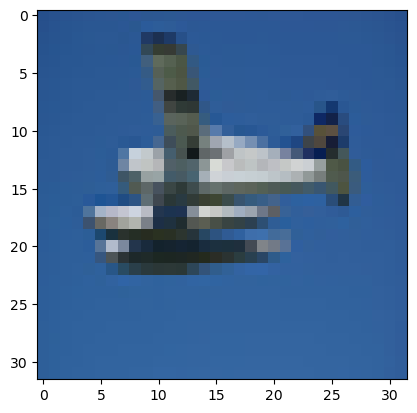

In [12]:
# Create a DataLoader
dataset = ActivationDataset('activations_cifar10_vit_b/cifar10_activations_0.h5','vit.encoder.layer.0.output')

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
input_image = next(iter(data_loader))[0][0]
plt.imshow(input_image.permute(1,2,0))
inputs = feature_extractor(images=to_pil(input_image), return_tensors="pt")

In [13]:
def get_top_indices(top_features, num_top=10):
    tops = []
    for i in top_features:
        tops.append(i.cpu().detach().numpy())
    tops = np.concatenate(tops)

    # Count the occurrences of each value
    value_counts = Counter(tops)

    # Create a dictionary with value and counts
    value_counts_dict = dict(value_counts)
    sorted_counts = sorted(value_counts_dict.items(), key=lambda x: x[1], reverse=True)
    sorted_indices = [index for index, _ in sorted_counts[:num_top]]
    
    return sorted_indices

In [14]:
# original
#input_image = transforms.ToPILImage()(input_image)

input1 = feature_extractor(images=input_image, return_tensors="pt")


input1.to(device)

activation_inputs1 = model(**input1)['hidden_states'][1:]

# initiate the encoder and encoder_bias for SAE
encoder = torch.randn((7680, 768)) # encoder
nn.init.xavier_uniform_(encoder)
encoder_bias = torch.zeros(7680) # encoder bias

# Create a SAE instance
tied_sae1 = TiedSAE(encoder, encoder_bias)
tied_sae1.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio5_epoch100_lr0.0001.pth'))
tied_sae1.to_device(device)

tied_sae2 = TiedSAE(encoder, encoder_bias)
tied_sae2.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth'))
tied_sae2.to_device(device)

tied_sae3 = TiedSAE(encoder, encoder_bias)
tied_sae3.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth'))
tied_sae3.to_device(device)

tied_sae4 = TiedSAE(encoder, encoder_bias)
tied_sae4.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio20_epoch100_lr0.0001.pth'))
tied_sae4.to_device(device)

tied_sae5 = TiedSAE(encoder, encoder_bias)
tied_sae5.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio30_epoch100_lr0.0001.pth'))
tied_sae5.to_device(device)


# Calculate the activation levels for the input patch
original =[]
sae5 = []
sae10 = []
sae15 = []
sae20 = []
sae30 = []

for i in range(5,9):
    original.append(activation_inputs1[i].squeeze(0))
    sae5.append(tied_sae1.encode(activation_inputs1[i]).squeeze(0))
    sae10.append(tied_sae2.encode(activation_inputs1[i]).squeeze(0))
    sae15.append(tied_sae3.encode(activation_inputs1[i]).squeeze(0))
    sae20.append(tied_sae4.encode(activation_inputs1[i]).squeeze(0))
    sae30.append(tied_sae5.encode(activation_inputs1[i]).squeeze(0))

top_features_original = []
top_features_sae5 = []
top_features_sae10 = []
top_features_sae15 = []
top_features_sae20 = []
top_features_sae30 = []

for i in range(4):
    # Detach the tensors before passing them to torch.topk()
    tensor1 = original[i].mean(dim=0).detach().cpu()
    tensor2 = sae5[i].mean(dim=0).detach().cpu()
    tensor3 = sae10[i].mean(dim=0).detach().cpu()
    tensor4 = sae15[i].mean(dim=0).detach().cpu()
    tensor5 = sae20[i].mean(dim=0).detach().cpu()
    tensor6 = sae30[i].mean(dim=0).detach().cpu()
    
    top_features_original.append(torch.topk(tensor1, k=30, largest=True).indices)
    top_features_sae5.append(torch.topk(tensor2, k=30, largest=True).indices)
    top_features_sae10.append(torch.topk(tensor3, k=30, largest=True).indices)
    top_features_sae15.append(torch.topk(tensor4, k=30, largest=True).indices)
    top_features_sae20.append(torch.topk(tensor5, k=30, largest=True).indices)
    top_features_sae30.append(torch.topk(tensor6, k=30, largest=True).indices)
    
# extract top 10 features that activated in a input across all layers


top_indices1 = get_top_indices(top_features_original)
top_indices2 = get_top_indices(top_features_sae5)
top_indices3 = get_top_indices(top_features_sae10)
top_indices4 = get_top_indices(top_features_sae15)
top_indices5 = get_top_indices(top_features_sae20)
top_indices6 = get_top_indices(top_features_sae30)


original


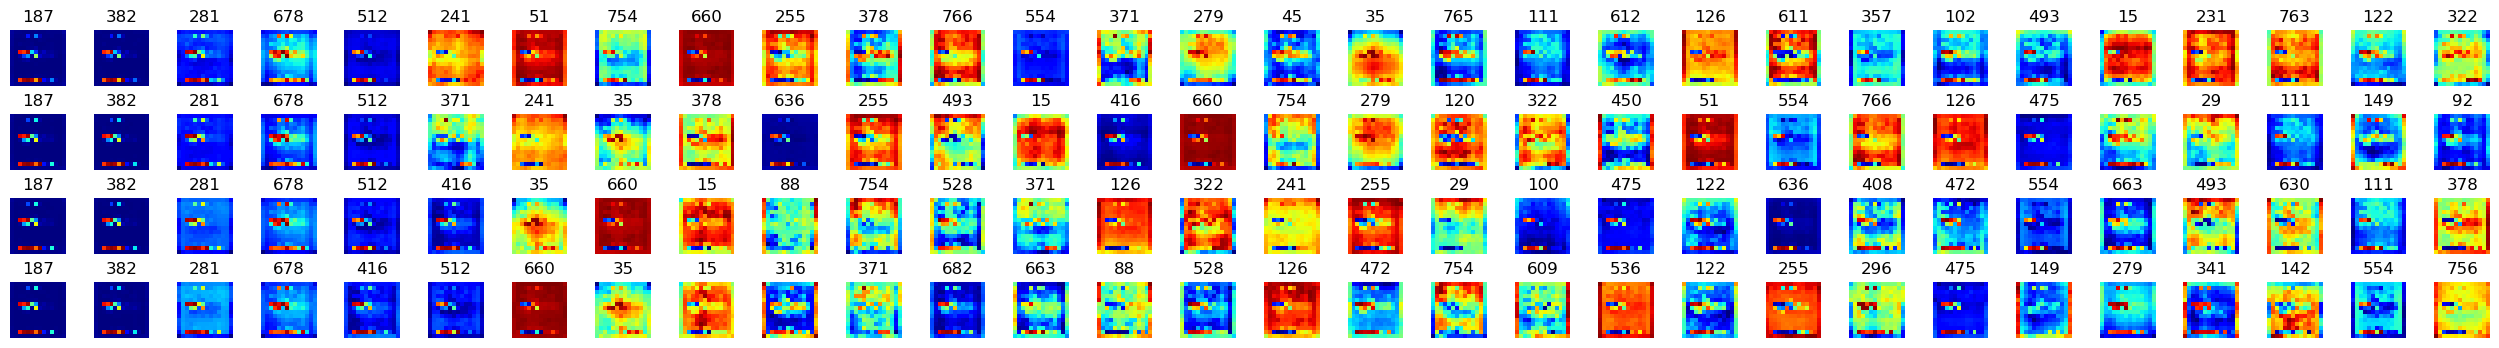

sae5


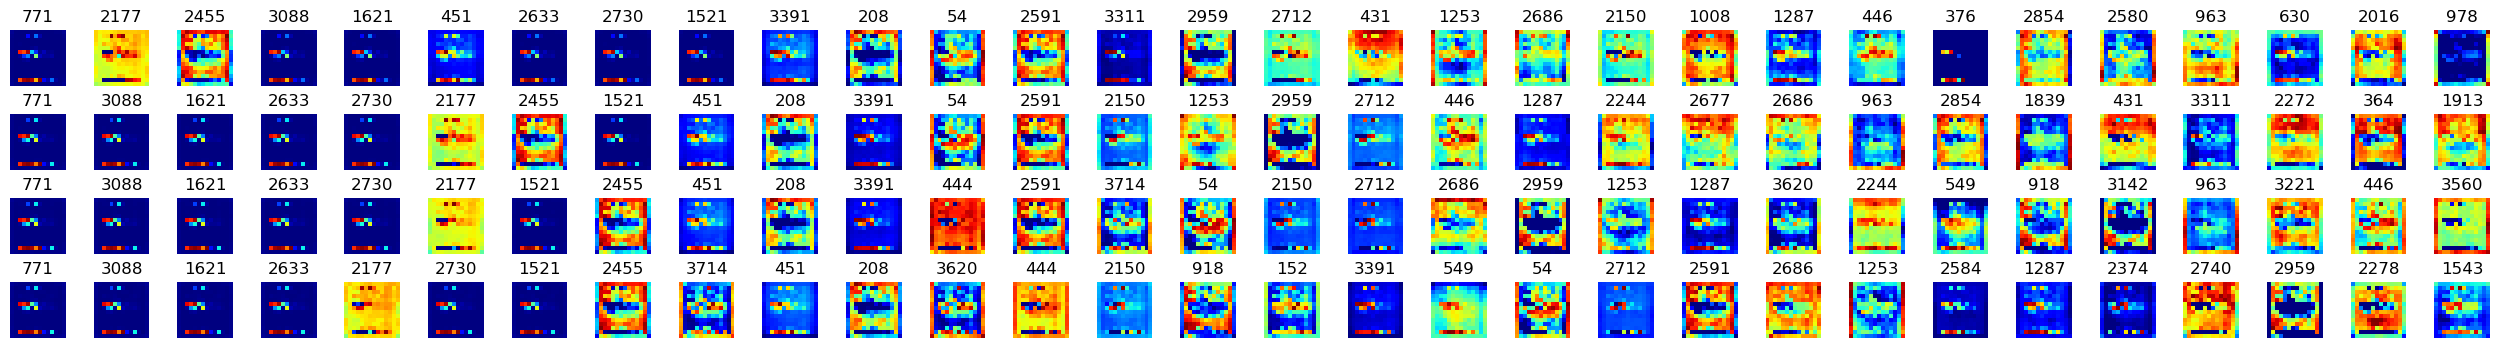

sae10


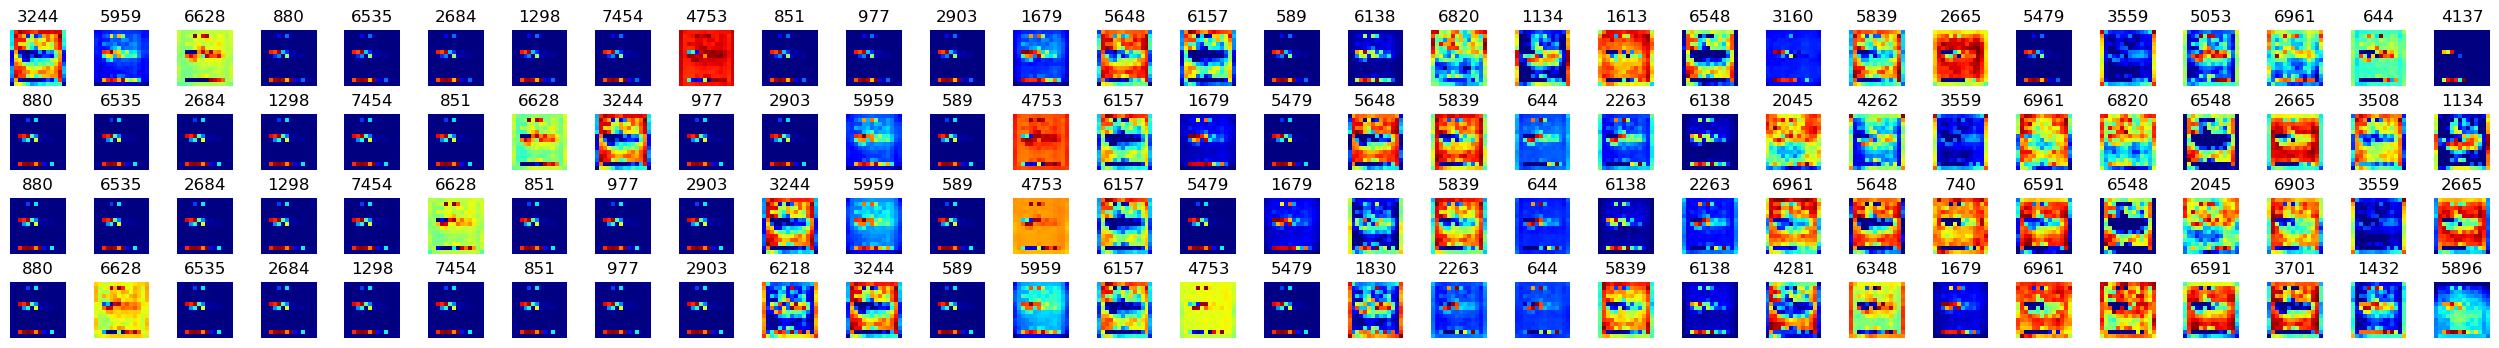

sae15


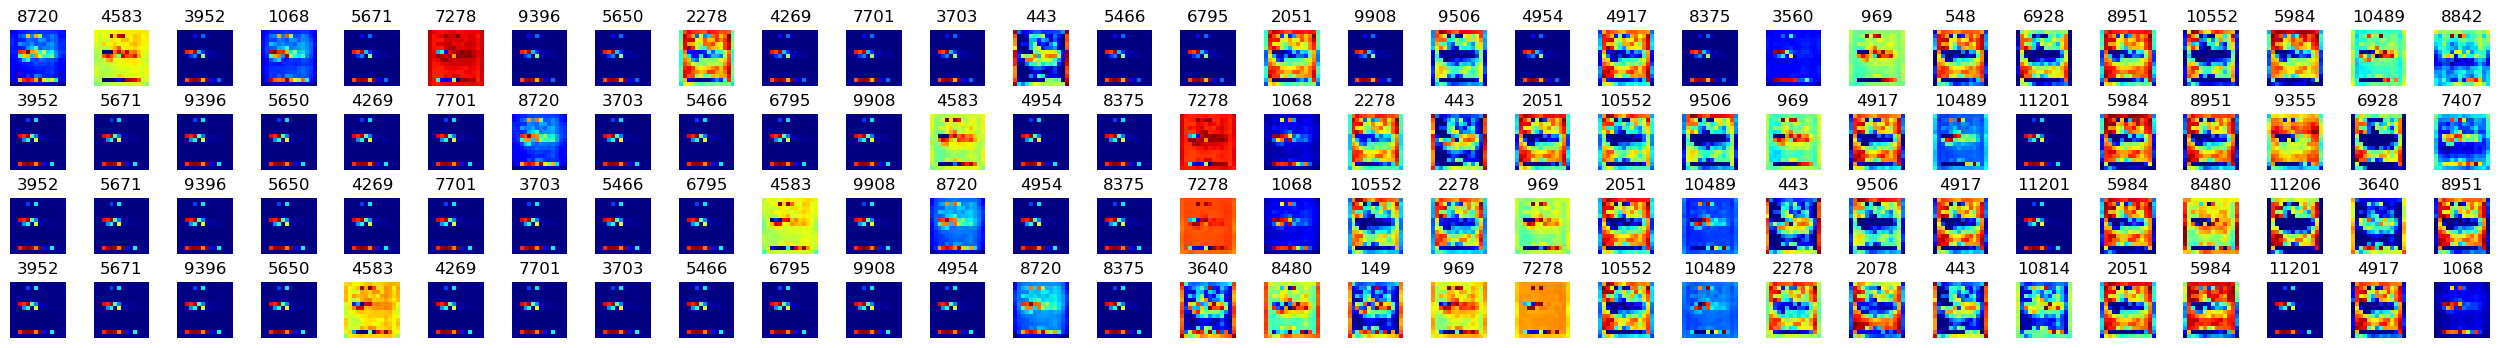

sae20


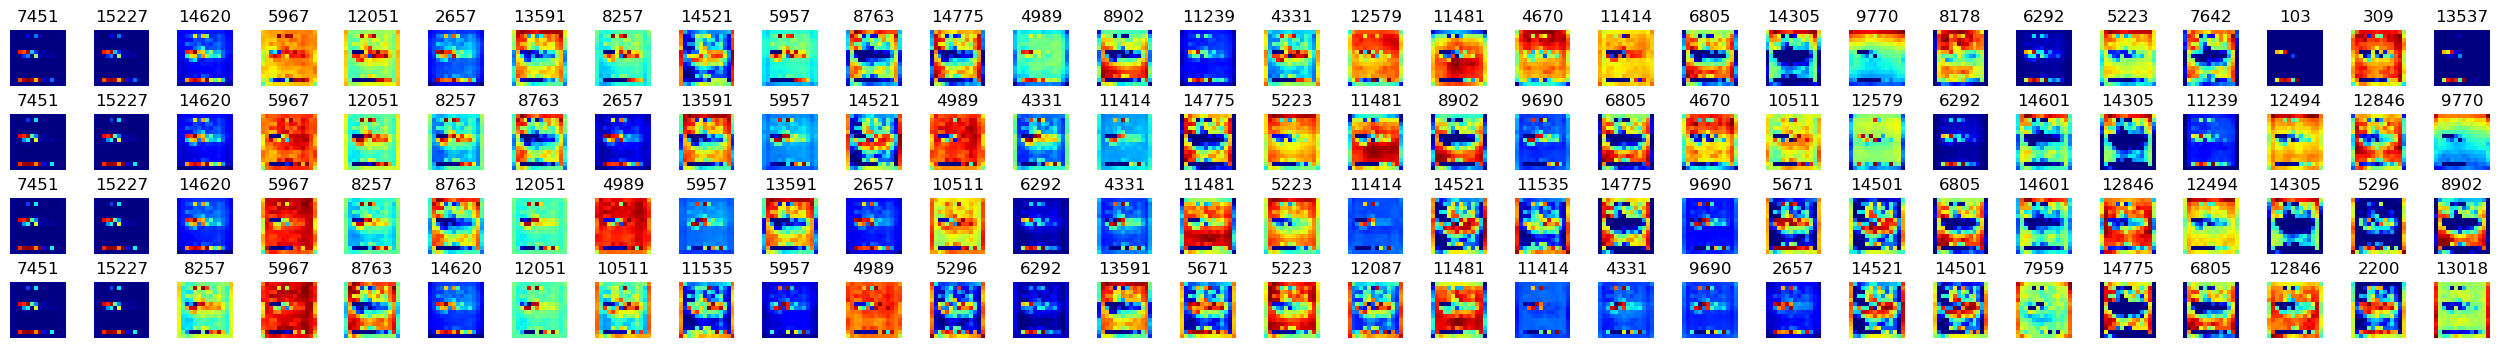

sae30


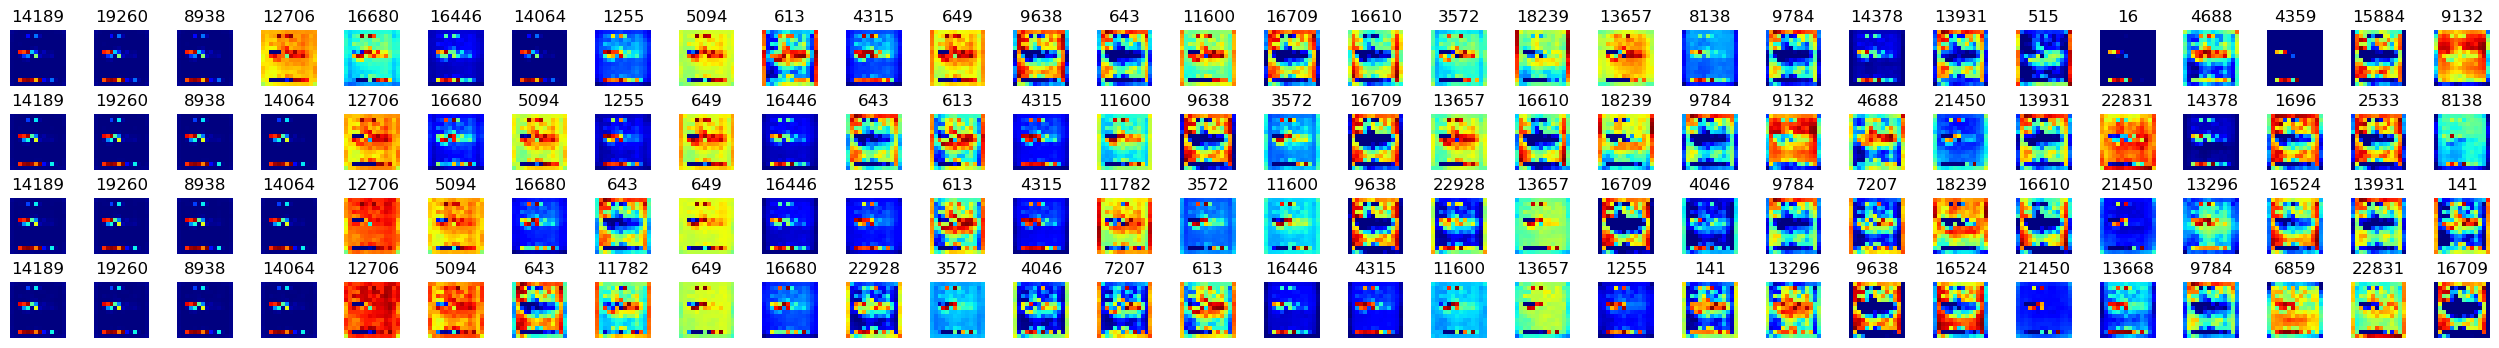

In [15]:
# Define a function to create a heatmap
def create_heatmap(activations, top_features):
    fig, axs = plt.subplots(4, 30, figsize=(32, 4))
    for i, layer_features in enumerate(top_features):
        for j, feature in enumerate(layer_features):
            ax = axs[i, j]
            sns.heatmap(activations[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
            ax.set_title(f'{feature}')
            ax.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
    plt.show()

# Call the function for each image
print('original')
create_heatmap(original, top_features_original)
print('sae5')
create_heatmap(sae5, top_features_sae5)
print('sae10')
create_heatmap(sae10, top_features_sae10)
print('sae15')
create_heatmap(sae15, top_features_sae15)
print('sae20')
create_heatmap(sae20, top_features_sae20)
print('sae30')
create_heatmap(sae30, top_features_sae30)
